# King County House Sale - Modeling

## Initial Setup

In [64]:
#Setting up environment with initial libraries needed for importing, cleaning, and initial visualization
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import probplot

import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import sweetviz as sv

import cufflinks as cf
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)
pd.set_option('display.float_format', '{:,}'.format)

sns.set_style('darkgrid')

%matplotlib inline

kchouse_model = pd.read_csv('kchouse_model.csv')

In [34]:
#define function to iterate through columns for custom descriptive statistics table
def eda_table(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isna().sum()
    eda_df['null_prct'] = df.isna().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

### Sweet Viz and Pandas Profile Report

In [35]:
#create sweet viz visualization for model dataset and export to html
#sweetviz_base = sv.analyze(kchouse_model, target_feat = 'price')
#sweetviz_base.show_html('sweetviz_model.html')

#### Link to Sweet Viz visualizations: [sweetviz_model.html](sweetviz_model.html)

#### Link to Pandas Profile for model dataset: [kchouseprofile_model.html](kchouseprofile_model.html)

In [36]:
kchouse_model.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,city,livable,q2_2014,q3_2014,q4_2014,q1_2015,q2_2015,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15
0,0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,...,Seattle,1,0,0,1,0,0,7.073269717459709,8.639410824140487,7.073269717459709,7.200424892944957,8.639410824140487
1,1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,...,Seattle,1,0,0,1,0,0,7.851661177889265,8.887652690325586,7.6824824465345065,7.432483807917119,8.94102198354136
2,2,5631500400,2015-02-25,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,...,Kenmore,1,0,0,0,1,0,6.646390514847728,9.210340371976184,6.646390514847728,7.908387159290043,8.994916943677111
3,3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,...,Seattle,1,0,0,1,0,0,7.580699752224562,8.517193191416238,6.956545443151568,7.215239978730098,8.517193191416238
4,4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,...,Sammamish,1,0,0,0,1,0,7.426549072397305,8.997147151515144,7.426549072397305,7.495541943884256,8.923058219545727


In [37]:
kchouse_model.describe()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,livable,q2_2014,q3_2014,q4_2014,q1_2015,q2_2015,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15
count,"21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0",...,"21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0","21,593.0"
mean,"10,798.316259899042","4,580,300,249.665308","540,352.6882786088",3.372018709767054,2.1161255962580467,"2,080.4784420877136","15,101.193396007966",1.4941416199694346,0.006761450470059742,0.23322372991247164,3.409855045616635,7.658176260825267,...,"12,759.564210623814",0.9796693372852313,0.18274440790997082,0.2741629231695457,0.2201176307136572,0.1898300375121567,0.13314500069466956,7.550824448748599,8.989903616131151,7.395281436695742,7.539531474350569,8.960825422816484
std,"6,234.958929956687","2,876,833,103.152996","367,377.5333122667",0.9039294469150001,0.7687409369657962,918.0763766864567,"41,416.25276230656",0.5396903707861491,0.08195147519339266,0.7647368185445763,0.6505755583822345,1.1730580386964635,...,"27,276.78982375412",0.14113202793291676,0.3864657891066632,0.4461018168475007,0.4143353832353193,0.39217562026273156,0.33973924539717665,0.42410642672015575,0.9020928296078294,0.4269842563373276,0.32748248953473064,0.8126546153215226
min,0.0,"1,000,102.0","78,000.0",1.0,0.75,370.0,520.0,1.0,0.0,0.0,1.0,3.0,...,651.0,0.0,0.0,0.0,0.0,0.0,0.0,5.913503005638269,6.253828811575472,5.913503005638269,5.988961416889863,6.478509642208568
25%,"5,399.0","2,123,049,142.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,...,"5,100.0",1.0,0.0,0.0,0.0,0.0,0.0,7.265429723253952,8.525161361065415,7.0817085861055755,7.306531398939504,8.536995818712418
50%,"10,798.0","3,904,930,240.0","450,000.0",3.0,2.25,"1,910.0","7,620.0",1.5,0.0,0.0,3.0,7.0,...,"7,620.0",1.0,0.0,0.0,0.0,0.0,0.0,7.554858521040676,8.938531648680692,7.352441100243581,7.517520850603031,8.938531648680692
75%,"16,198.0","7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,687.0",2.0,0.0,0.0,4.0,8.0,...,"10,083.0",1.0,0.0,1.0,0.0,0.0,0.0,7.843848638152473,9.276783328524896,7.7007477945117975,7.766416898019655,9.218606116393213
max,"21,596.0","9,900,000,190.0","7,700,000.0",11.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,...,"871,200.0",1.0,1.0,1.0,1.0,1.0,1.0,9.513403546466266,14.317109143238099,9.149528232579426,8.733916174927524,13.677626850600886


### Dropping columns that have log transform equivalents

In [38]:
kchouse_model = kchouse_model.drop(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)
kchouse_model.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,...,city,livable,q2_2014,q3_2014,q4_2014,q1_2015,q2_2015,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15
0,0,7129300520,2014-10-13,"221,900.0",3,1.0,1.0,0.0,0.0,3,7,0.0,...,Seattle,1,0,0,1,0,0,7.073269717459709,8.639410824140487,7.073269717459709,7.200424892944957,8.639410824140487
1,1,6414100192,2014-12-09,"538,000.0",3,2.25,2.0,0.0,0.0,3,7,400.0,...,Seattle,1,0,0,1,0,0,7.851661177889265,8.887652690325586,7.6824824465345065,7.432483807917119,8.94102198354136
2,2,5631500400,2015-02-25,"180,000.0",2,1.0,1.0,0.0,0.0,3,6,0.0,...,Kenmore,1,0,0,0,1,0,6.646390514847728,9.210340371976184,6.646390514847728,7.908387159290043,8.994916943677111
3,3,2487200875,2014-12-09,"604,000.0",4,3.0,1.0,0.0,0.0,5,7,910.0,...,Seattle,1,0,0,1,0,0,7.580699752224562,8.517193191416238,6.956545443151568,7.215239978730098,8.517193191416238
4,4,1954400510,2015-02-18,"510,000.0",3,2.0,1.0,0.0,0.0,3,8,0.0,...,Sammamish,1,0,0,0,1,0,7.426549072397305,8.997147151515144,7.426549072397305,7.495541943884256,8.923058219545727


In [39]:
eda_table(kchouse_model)

,null_sum,null_prct,dtypes,count,mean,median,min,max
Unnamed: 0,0,0.0,int64,21593,"10,798.316259899042","10,798.0",0,21596
bathrooms,0,0.0,float64,21593,2.1161255962580467,2.25,0.75,8.0
bedrooms,0,0.0,int64,21593,3.372018709767054,3.0,1,11
city,0,0.0,object,21593,nan,nan,Auburn,Woodinville
condition,0,0.0,int64,21593,3.409855045616635,3.0,1,5
date,0,0.0,object,21593,nan,nan,2014-05-02,2015-05-27
floors,0,0.0,float64,21593,1.4941416199694346,1.5,1.0,3.5
grade,0,0.0,int64,21593,7.658176260825267,7.0,3,13
id,0,0.0,int64,21593,"4,580,300,249.665308","3,904,930,240.0",1000102,9900000190
lat,0,0.0,float64,21593,47.560095595794934,47.5718,47.1559,47.7776


### OLS - Model 1

In [40]:
data = kchouse_model
target = 'price'
x_cols = kchouse_model.drop([target, 'date','id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model = smf.ols(formula=f, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1310.
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:49:11   Log-Likelihood:            -2.9293e+05
No. Observations:               21593   AIC:                         5.860e+05
Df Residuals:                   21546   BIC:                         5.863e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.653e+07    6.9e+06      9.642      0.000     5.3e+07    8.01e+07
city[T.Bellevue]       2.036e+05   1.03e+04     19.698      0.000    1.83e+05    2.24e+05
city[T.Black Diamond]  1.141e+05   2.12e+04      5.378      0.000    7.25e+04    1.56e+05
city[T.Bothell]       -1.041e+05   1.75e+04     -5.957      0.000   -1.38e+05   -6.98e+04
city[T.Carnation]      5.431e+04   2.31e+04      2.352      0.019    9047.867    9.96e+04
city[T.Duvall]        -2.837e+04   1.96e+04     -1.451      0.147   -6.67e+04    9956.558
city[T.Enumclaw]       8.833e+04   1.58e+04      5.597      0.000    5.74e+04    1.19e+05
city[T.Fall City]      1.535e+05   2.49e+04      6.169      0.000    1.05e+05    2.02e+05
city[T.Federal Way]    -9.31e+04   1.01e+04     -9.232      0.000   -1.13e+05   -7.33e+04
city[T.Issaquah]       1.051e+05   1.23e+04      8.523      0.000    8.09e+04    1.29e+05
city[T.Kenmore]       -9.562e+04   1.58e+04     -6.041      0.000   -1.27e+05   -6.46e+04
city[T.Kent]          -1826.9839   8619.129     -0.212      0.832   -1.87e+04    1.51e+04
city[T.Kirkland]       1.003e+05    1.2e+04      8.332      0.000    7.67e+04    1.24e+05
city[T.Maple Valley]   7.293e+04   1.17e+04      6.222      0.000       5e+04    9.59e+04
city[T.Medina]         1.181e+06   2.84e+04     41.586      0.000    1.13e+06    1.24e+06
city[T.Mercer Island]  3.527e+05   1.42e+04     24.896      0.000    3.25e+05     3.8e+05
city[T.North Bend]     1.802e+05   2.07e+04      8.726      0.000     1.4e+05    2.21e+05
city[T.Redmond]        1.207e+05   1.28e+04      9.404      0.000    9.56e+04    1.46e+05
city[T.Renton]         4.262e+04   9124.001      4.671      0.000    2.47e+04    6.05e+04
city[T.Sammamish]      1.376e+05   1.33e+04     10.351      0.000    1.12e+05    1.64e+05
city[T.Seattle]        1.984e+05   1.34e+04     14.772      0.000    1.72e+05    2.25e+05
city[T.Snoqualmie]      1.55e+05   1.79e+04      8.683      0.000     1.2e+05     1.9e+05
city[T.Vashon]        -6.662e+04    2.1e+04     -3.172      0.002   -1.08e+05   -2.54e+04
city[T.Woodinville]    2.796e+04   1.54e+04      1.821      0.069   -2133.883    5.81e+04
bedrooms               -2.06e+04   1947.281    -10.581      0.000   -2.44e+04   -1.68e+04
bathrooms              6.852e+04   3062.246     22.374      0.000    6.25e+04    7.45e+04
floors                -4486.3182   3844.892     -1.167      0.243    -1.2e+04    3049.956
waterfront             6.572e+05   1.72e+04     38.258      0.000    6.24e+05    6.91e+05
view                   4.522e+04   2019.421     22.395      0.000    4.13e+04    4.92e+04
condition              2.975e+04   2288.608     12.998      0.000    2.53e+04    3.42e+04
grade                  1.162e+05   2051.885     56.638      0.000    1.12e+05     1.2e+05
sqft_basement          

R-squared value down to .737!

## Multicollinearity

<AxesSubplot:>

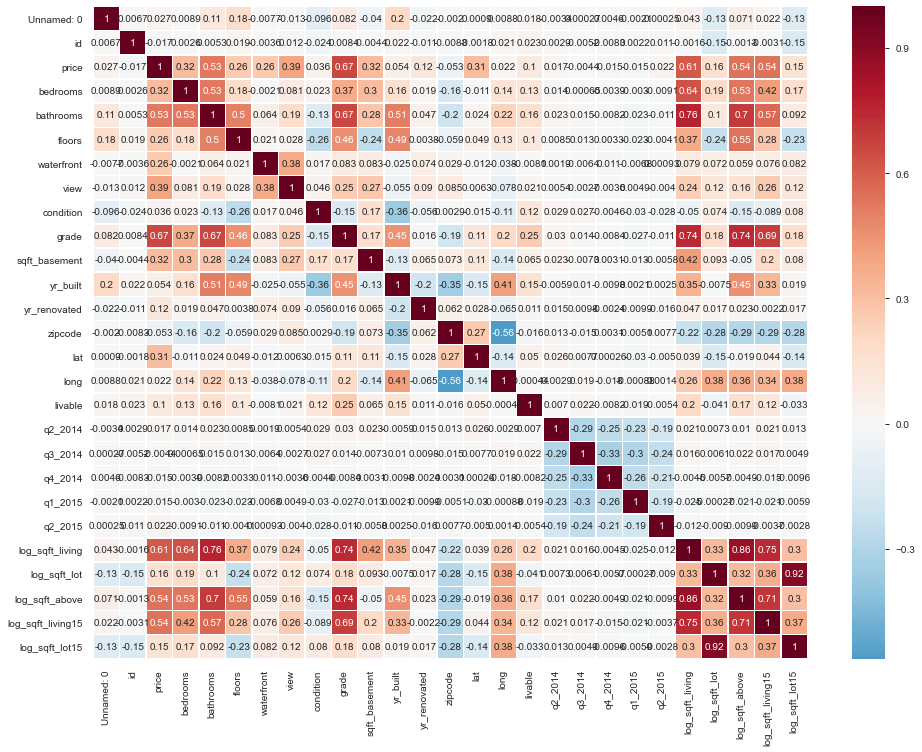

In [41]:
#create correlation heatmap to visualize collinearity
plt.figure(figsize=(16,12))
pcorr = kchouse_model.corr()
cmap = 'RdBu_r'
sns.heatmap(pcorr, 
            xticklabels=pcorr.columns, 
            yticklabels=pcorr.columns,
            cmap=cmap,
            annot=True,
            linewidth=0.5,
            center=0)

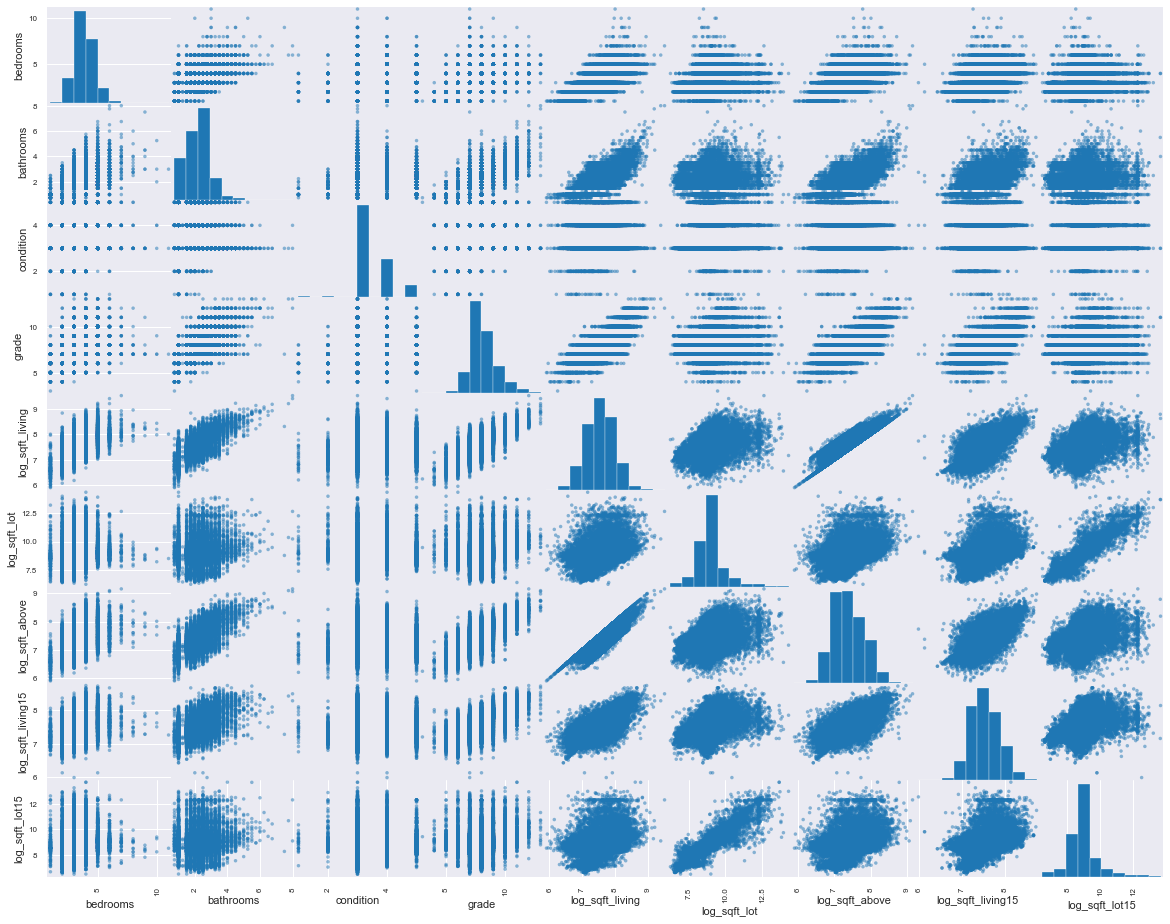

In [42]:
#create a scatterplot matrix of select predictor variables
pred = ['bedrooms', 'bathrooms', 'condition', 'grade', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15']
kchouse_pred = kchouse_model[pred]
pd.plotting.scatter_matrix(kchouse_pred,figsize  = [20, 16]);
plt.show()

In [43]:
#call correlation stats for predictor variables
kchouse_pred.corr()

,bedrooms,bathrooms,condition,grade,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15
bedrooms,1.0,0.5277530348839268,0.023361266929830916,0.36592047931946037,0.637524002521876,0.18981010598841647,0.5300488624768226,0.41816888789456663,0.16707036279567883
bathrooms,0.5277530348839268,1.0,-0.12663229943418733,0.6657850106118681,0.7621540412275915,0.10044212415251492,0.695785934777404,0.5718154181124852,0.09184266482440007
condition,0.023361266929830916,-0.12663229943418733,1.0,-0.14697345489897545,-0.04971097413718952,0.07363688274183691,-0.15083333920798203,-0.08926789277975655,0.07980462199341093
grade,0.36592047931946037,0.6657850106118681,-0.14697345489897545,1.0,0.7429208411139804,0.18424664549292993,0.7427671891844515,0.6890568760852902,0.18492833363893346
log_sqft_living,0.637524002521876,0.7621540412275915,-0.04971097413718952,0.7429208411139804,1.0,0.325939532295306,0.8649413856627083,0.7468951530613002,0.3030043170519009
log_sqft_lot,0.18981010598841647,0.10044212415251492,0.07363688274183691,0.18424664549292993,0.325939532295306,1.0,0.31860079000905245,0.363707731041516,0.918667735842804
log_sqft_above,0.5300488624768226,0.695785934777404,-0.15083333920798203,0.7427671891844515,0.8649413856627083,0.31860079000905245,1.0,0.713187140196981,0.29866312222131697
log_sqft_living15,0.41816888789456663,0.5718154181124852,-0.08926789277975655,0.6890568760852902,0.7468951530613002,0.363707731041516,0.713187140196981,1.0,0.3735951380919623
log_sqft_lot15,0.16707036279567883,0.09184266482440007,0.07980462199341093,0.18492833363893346,0.3030043170519009,0.918667735842804,0.29866312222131697,0.3735951380919623,1.0


In [44]:
#generate matrix of predictor collinearity greater than .7
abs(kchouse_pred.corr()) > 0.7

,bedrooms,bathrooms,condition,grade,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15
bedrooms,True,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,True,False,False,False,False
condition,False,False,True,False,False,False,False,False,False
grade,False,False,False,True,True,False,True,False,False
log_sqft_living,False,True,False,True,True,False,True,True,False
log_sqft_lot,False,False,False,False,False,True,False,False,True
log_sqft_above,False,False,False,True,True,False,True,True,False
log_sqft_living15,False,False,False,False,True,False,True,True,False
log_sqft_lot15,False,False,False,False,False,True,False,False,True


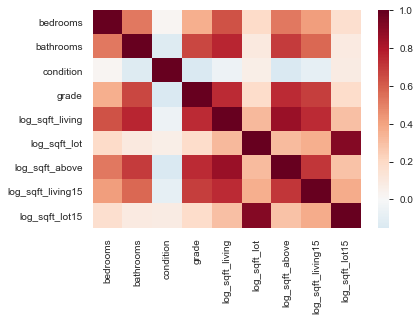

In [45]:
#create heatmap of predictor variables
import seaborn as sns
sns.heatmap(kchouse_pred.corr(), cmap=cmap, center=0);

In [46]:
#dropping log_sqft_above from model dataframe as it is indicated in log_sqft_living
kchouse_model = kchouse_model.drop(['log_sqft_above'], axis=1)
kchouse_model.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,...,long,city,livable,q2_2014,q3_2014,q4_2014,q1_2015,q2_2015,log_sqft_living,log_sqft_lot,log_sqft_living15,log_sqft_lot15
0,0,7129300520,2014-10-13,"221,900.0",3,1.0,1.0,0.0,0.0,3,7,0.0,...,-122.257,Seattle,1,0,0,1,0,0,7.073269717459709,8.639410824140487,7.200424892944957,8.639410824140487
1,1,6414100192,2014-12-09,"538,000.0",3,2.25,2.0,0.0,0.0,3,7,400.0,...,-122.319,Seattle,1,0,0,1,0,0,7.851661177889265,8.887652690325586,7.432483807917119,8.94102198354136
2,2,5631500400,2015-02-25,"180,000.0",2,1.0,1.0,0.0,0.0,3,6,0.0,...,-122.233,Kenmore,1,0,0,0,1,0,6.646390514847728,9.210340371976184,7.908387159290043,8.994916943677111
3,3,2487200875,2014-12-09,"604,000.0",4,3.0,1.0,0.0,0.0,5,7,910.0,...,-122.393,Seattle,1,0,0,1,0,0,7.580699752224562,8.517193191416238,7.215239978730098,8.517193191416238
4,4,1954400510,2015-02-18,"510,000.0",3,2.0,1.0,0.0,0.0,3,8,0.0,...,-122.045,Sammamish,1,0,0,0,1,0,7.426549072397305,8.997147151515144,7.495541943884256,8.923058219545727


### OLS - Model 2

In [47]:
data = kchouse_model
target = 'price'
x_cols = kchouse_model.drop([target, 'date','id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model = smf.ols(formula=f, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1246.
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:50:03   Log-Likelihood:            -2.9350e+05
No. Observations:               21593   AIC:                         5.871e+05
Df Residuals:                   21547   BIC:                         5.875e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.125e+07   7.08e+06      8.648      0.000    4.74e+07    7.51e+07
city[T.Bellevue]       2.051e+05   1.06e+04     19.327      0.000    1.84e+05    2.26e+05
city[T.Black Diamond]  1.021e+05   2.18e+04      4.687      0.000    5.94e+04    1.45e+05
city[T.Bothell]       -1.089e+05   1.79e+04     -6.067      0.000   -1.44e+05   -7.37e+04
city[T.Carnation]      3.707e+04   2.37e+04      1.564      0.118   -9391.431    8.35e+04
city[T.Duvall]        -3.749e+04   2.01e+04     -1.867      0.062   -7.68e+04    1864.911
city[T.Enumclaw]       8.557e+04   1.62e+04      5.281      0.000    5.38e+04    1.17e+05
city[T.Fall City]      1.343e+05   2.55e+04      5.259      0.000    8.42e+04    1.84e+05
city[T.Federal Way]   -9.438e+04   1.04e+04     -9.115      0.000   -1.15e+05   -7.41e+04
city[T.Issaquah]       9.545e+04   1.27e+04      7.542      0.000    7.06e+04     1.2e+05
city[T.Kenmore]        -1.05e+05   1.62e+04     -6.465      0.000   -1.37e+05   -7.32e+04
city[T.Kent]          -5166.4491   8848.959     -0.584      0.559   -2.25e+04    1.22e+04
city[T.Kirkland]       9.355e+04   1.24e+04      7.572      0.000    6.93e+04    1.18e+05
city[T.Maple Valley]   6.629e+04    1.2e+04      5.509      0.000    4.27e+04    8.99e+04
city[T.Medina]         1.195e+06   2.92e+04     40.985      0.000    1.14e+06    1.25e+06
city[T.Mercer Island]  3.628e+05   1.45e+04     24.949      0.000    3.34e+05    3.91e+05
city[T.North Bend]     1.617e+05   2.12e+04      7.628      0.000     1.2e+05    2.03e+05
city[T.Redmond]         1.08e+05   1.32e+04      8.198      0.000    8.22e+04    1.34e+05
city[T.Renton]         3.515e+04   9365.212      3.753      0.000    1.68e+04    5.35e+04
city[T.Sammamish]      1.152e+05   1.36e+04      8.450      0.000    8.85e+04    1.42e+05
city[T.Seattle]        1.725e+05   1.38e+04     12.535      0.000    1.46e+05       2e+05
city[T.Snoqualmie]     1.466e+05   1.83e+04      7.996      0.000    1.11e+05    1.82e+05
city[T.Vashon]         -8.16e+04   2.16e+04     -3.784      0.000   -1.24e+05   -3.93e+04
city[T.Woodinville]    7728.9309   1.58e+04      0.491      0.624   -2.31e+04    3.86e+04
bedrooms              -1.842e+04   1998.260     -9.219      0.000   -2.23e+04   -1.45e+04
bathrooms              7.323e+04   3140.916     23.314      0.000    6.71e+04    7.94e+04
floors                 2.396e+04   3854.068      6.218      0.000    1.64e+04    3.15e+04
waterfront             6.666e+05   1.76e+04     37.801      0.000    6.32e+05    7.01e+05
view                   5.142e+04   2065.023     24.902      0.000    4.74e+04    5.55e+04
condition              2.664e+04   2347.933     11.347      0.000     2.2e+04    3.12e+04
grade                  1.274e+05   2079.668     61.270      0.000    1.23e+05    1.31e+05
sqft_basement          

R-squared value at .722!

## Train_Test_Split

In [56]:
data = kchouse_model
y = data['price']
X = data.drop(['price','date','id','zipcode', 'city'], axis = 1)

In [57]:
# create data sets with an 80/20 split - train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [58]:
len(y_test)

4319

In [59]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 37082909849.31845
Test Mean Squarred Error: 37489851570.197845


In [60]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 192569.23391164656
Test Root Mean Squarred Error: 193622.9624042506


In [ ]:
df_final = kchouse_model

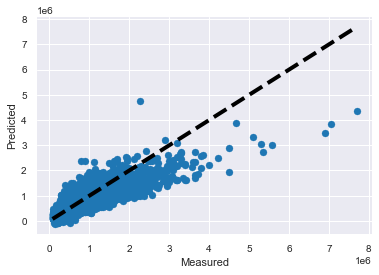

In [66]:
predicted = cross_val_predict(linreg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

<AxesSubplot:xlabel='price'>

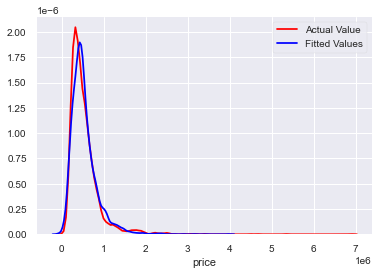

In [63]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat_test, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [ ]:
base_y_predicted = base_linreg.predict(base_X)
base_residuals = base_y - base_y_predicted

_ = probplot(base_residuals, plot=plt)

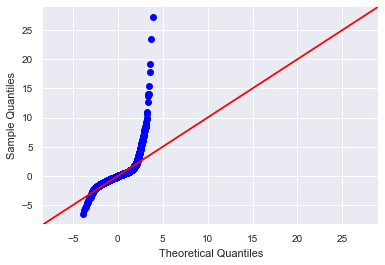

In [67]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)